# Introduction

This notebook explores [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) using the [french version of Odyssée](http://www.gutenberg.org/files/14286/14286-r.zip).

# Setup

Install some libraries:

In [0]:
%%capture
!conda install -y -c conda-forge spacy
!pip install plotly
!python -m spacy download en

Navigate to the projects root folder:

In [8]:
%cd ..

/


# Libraries

In [9]:
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import plotly
plotly.offline.init_notebook_mode(connected=True)

import spacy
import collections

import scipy

# Data

Download the odyssee book:

In [10]:
!wget --continue --directory-prefix=./data http://www.gutenberg.org/files/14286/14286-r.zip
!unzip -n ./data/14286-r.zip -d ./data

--2020-03-28 08:00:19--  http://www.gutenberg.org/files/14286/14286-r.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  ./data/14286-r.zip


# Explore

List available files in the extracted zip file:

In [11]:
%ls -la ./data/

total 1052
drwxr-xr-x 2 root root   4096 Mar 28 07:49 ./
drwxr-xr-x 1 root root   4096 Mar 28 07:49 ../
-rw-r--r-- 1 root root 821351 Mar  6  2005 14286-r.rtf
-rw-r--r-- 1 root root 245664 Mar  6  2005 14286-r.zip


In [0]:
input_file = './data/14286-r.rtf'

In [13]:
!python -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


A pipeline component to ignore certain tokens:

In [0]:
class TokenKeeper:
    name='the_token_ignorer'
    def __init__(self, blacklist_tokens=[]):
        self.blacklist_tokens=blacklist_tokens
        spacy.tokens.Token.set_extension('is_ignored', default=False, force=True)
    
    def __call__(self, doc):
        for token in doc:
            if not token.is_alpha or token.text in self.blacklist_tokens:
                token._.set('is_ignored', True)
        
        return doc

In [0]:
import fr_core_news_md
nlp = fr_core_news_md.load()
nlp.add_pipe(TokenKeeper(), first=True)

For each line in the dataset, track the frequency of each tokens:

In [22]:
%%time
counter = collections.Counter()

with open(input_file) as f:
    for line in f:
        doc = nlp(line)
        for token in doc:
            if not token._.is_ignored:
                counter[token.lower_] = counter[token.lower_] + 1

CPU times: user 1min 20s, sys: 21.7 ms, total: 1min 20s
Wall time: 1min 20s


Convert the counter into a pandas dataframe:

In [48]:
df = pd \
    .DataFrame.from_dict(counter, orient='index') \
    .sort_values(0, ascending=False) \
    .reset_index() \
    .rename(columns={'index':'word', 0:'count'})

df.index = df.index + 1

df.head(10).T

,1,2,3,4,5,6,7,8,9,10
word,et,de,la,les,le,il,dans,je,que,des
count,7044,4056,3073,2796,2634,2062,1422,1376,1367,1288


Compute the proportion that each word appear inside the corpus:

In [49]:
df['proportion'] = df['count']/df['count'].sum()
df.head()

,word,count,proportion
1,et,7044,0.070012
2,de,4056,0.040314
3,la,3073,0.030543
4,les,2796,0.027790
5,le,2634,0.026180


Compute number of tokens and vocab size of the corpus:

In [50]:
vocab_size, _ = df.shape
n_tokens = df['count'].sum()

print(f'Vocabulary size: {vocab_size:>8,}\nNumber of tokens: {n_tokens:,}')

Vocabulary size:    6,634
Number of tokens: 100,611


Compute the predicted proprotion using classic [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law):

In [51]:
def classic_zipf(N, k, s=1):
    return (1/k**s)/(np.sum(1/(np.arange(1, N+1)**s)))

# view some samples
N = n_tokens

for i in range(0, 3):
    print(f'N={N:,}, k={10**i:<3}: {classic_zipf(N, 10**i):.4f}')

N=100,611, k=1  : 0.0827
N=100,611, k=10 : 0.0083
N=100,611, k=100: 0.0008


In [52]:
%%time
vectorize_classic_zipf = np.vectorize(lambda x: classic_zipf(N, x))

df['predicted_proportion'] = vectorize_classic_zipf(df.index.values)

CPU times: user 5.5 s, sys: 151 ms, total: 5.65 s
Wall time: 5.66 s


In [53]:
df.head()

,word,count,proportion,predicted_proportion
1,et,7044,0.070012,0.082670
2,de,4056,0.040314,0.041335
3,la,3073,0.030543,0.027557
4,les,2796,0.027790,0.020668
5,le,2634,0.026180,0.016534


View the 10 most common, average and least common words:

In [54]:
df.head(10)

,word,count,proportion,predicted_proportion
1,et,7044,0.070012,0.082670
2,de,4056,0.040314,0.041335
3,la,3073,0.030543,0.027557
4,les,2796,0.027790,0.020668
5,le,2634,0.026180,0.016534
6,il,2062,0.020495,0.013778
7,dans,1422,0.014134,0.011810
8,je,1376,0.013676,0.010334
9,que,1367,0.013587,0.009186
10,des,1288,0.012802,0.008267


In [76]:
df.iloc[3300:3310]

,word,count,proportion,predicted_proportion,expected_count
3301,mordant,2,0.00002,0.000025,2.519705
3302,surveillant,2,0.00002,0.000025,2.518942
3303,nearly,2,0.00002,0.000025,2.518179
3304,nera,2,0.00002,0.000025,2.517417
3305,protect,2,0.00002,0.000025,2.516655
3306,inconnus,2,0.00002,0.000025,2.515894
3307,poussons,2,0.00002,0.000025,2.515133
3308,rules,2,0.00002,0.000025,2.514373
3309,perseus,2,0.00002,0.000025,2.513613
3310,federal,2,0.00002,0.000025,2.512853


In [55]:
df.tail(10)

,word,count,proportion,predicted_proportion
6625,fuyons,1,0.00001,0.000012
6626,viter,1,0.00001,0.000012
6627,empoisonneuse,1,0.00001,0.000012
6628,approchais,1,0.00001,0.000012
6629,adolescence,1,0.00001,0.000012
6630,collines,1,0.00001,0.000012
6631,ignorant,1,0.00001,0.000012
6632,closes,1,0.00001,0.000012
6633,resteras,1,0.00001,0.000012
6634,hear,1,0.00001,0.000012


# Visualization

log-log plot using the predicted proportion:

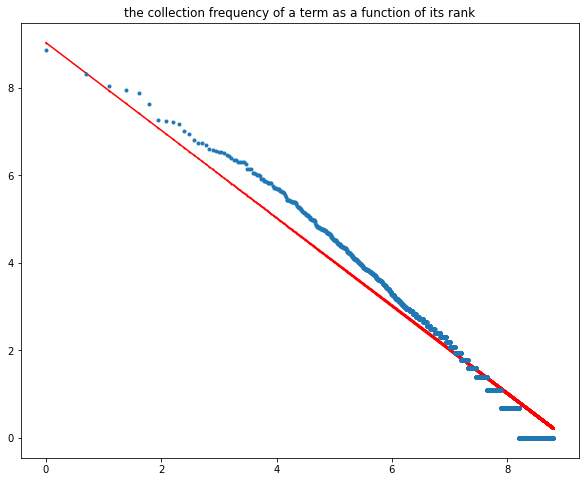

In [73]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=((10,8)))
x = np.log(df.index.values)
y = np.log(df['predicted_proportion'] * n_tokens)
ed = plt.plot(x, y, 'ro-',markersize=1,label='Line 2')

y_prop = np.log(df['proportion'] * n_tokens)
plt.title('the collection frequency of a term as a function of its rank', fontdict=None, loc='center', pad=None)
plt.plot(x, y_prop, 'o',markersize=3)
plt.show()


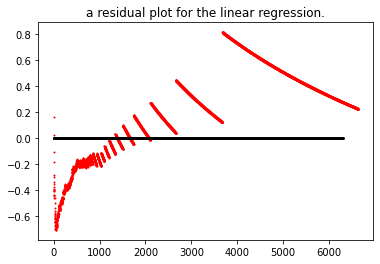

In [74]:
zero = np.zeros([6304])
plt.plot(Residual,'o', color='red',markersize=1) # plotting by columns
plt.plot(zero,'o', color='black',markersize=1)
plt.title('a residual plot for the linear regression.', fontdict=None, loc='center', pad=None)
plt.show()

In [0]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, y_prop)

In [61]:
r_value

0.9898704390288627

# Statistical Tests

In [0]:
actual_count = df_chi['count']
expected_count = df_chi['expected_count']

In [78]:
test_stat, p_value = scipy.stats.chisquare(actual_count, expected_count)
print(f'test statistic value: {test_stat:,.4f}')
print(f'p-value: {p_value: > 24}')
print(f'p-value < 0.05: {"yes" if p_value < 5/100 else "no":>17}')

test statistic value: 18,026.8425
p-value:                      0.0
p-value < 0.05:               yes
